In [25]:
# Cell 1: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
import joblib


In [26]:
# Cell 2: Load dataset
df = pd.read_csv("D:\Workspace\Projects\CTS\Dataset\CDR-Call-Details.csv")

# Drop phone number (not useful)
df = df.drop(columns=["Phone Number"])
df.head()


,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [27]:
# Cell 3: KMeans for Usage Category
usage_features = df[["Day Mins", "Eve Mins", "Night Mins"]]

kmeans = KMeans(n_clusters=3, random_state=42)
df["UsageCategory"] = kmeans.fit_predict(usage_features)

# Sort clusters into Low/Medium/High by Day Mins
cluster_means = df.groupby("UsageCategory")[["Day Mins"]].mean().sort_values("Day Mins")
mapping = {cluster: label for cluster, label in zip(cluster_means.index, [0,1,2])}  # 0=Low, 1=Medium, 2=High
df["UsageCategory"] = df["UsageCategory"].map(mapping)


In [28]:
# Cell 4: Prepare Features & Targets
X = df.drop(columns=["Churn", "UsageCategory"])
y = df[["Churn", "UsageCategory"]]  # two targets

# Encode churn (bool → 0/1)
y["Churn"] = y["Churn"].astype(int)


C:\Users\samsd\AppData\Local\Temp\ipykernel_28048\3125259587.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["Churn"] = y["Churn"].astype(int)


In [29]:
# Cell 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
# Cell 6: Build Multi-Output Model
xgb = XGBClassifier(eval_metric="mlogloss", use_label_encoder=False, random_state=42)

multi_model = MultiOutputClassifier(xgb)
multi_model.fit(X_train, y_train)


MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))

In [31]:
# Cell 7: Evaluate
y_pred = multi_model.predict(X_test)

print("Sample Predictions:")
for i in range(5):
    print(f"Churn: {y_pred[i][0]} | UsageCategory: {y_pred[i][1]}")


Sample Predictions:
Churn: 0 | UsageCategory: 0
Churn: 0 | UsageCategory: 0
Churn: 0 | UsageCategory: 0
Churn: 0 | UsageCategory: 0
Churn: 0 | UsageCategory: 0


In [21]:
# Cell 8: Save Model
joblib.dump(multi_model, "churn_usage_model.pkl")
print("✅ Model saved as churn_usage_model.pkl")


✅ Model saved as churn_usage_model.pkl


In [32]:
# Cell 9: Evaluation Metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss

# Predictions
y_pred = multi_model.predict(X_test)

# --- Accuracy ---
acc_churn = accuracy_score(y_test["Churn"], y_pred[:,0])
acc_usage = accuracy_score(y_test["UsageCategory"], y_pred[:,1])

# --- F1 Score ---
f1_churn = f1_score(y_test["Churn"], y_pred[:,0])
f1_usage = f1_score(y_test["UsageCategory"], y_pred[:,1], average="macro")

# --- ROC-AUC (only for churn, binary) ---
y_proba = multi_model.estimators_[0].predict_proba(X_test)[:,1]  # churn probability
roc_auc = roc_auc_score(y_test["Churn"], y_proba)

# --- Log Loss (error percentage style) ---
loss_churn = log_loss(y_test["Churn"], y_proba)
loss_percent = loss_churn * 100

print("📊 Evaluation Results")
print(f"Churn Accuracy     : {acc_churn:.4f}")
print(f"Usage Accuracy     : {acc_usage:.4f}")
print(f"Churn F1 Score     : {f1_churn:.4f}")
print(f"Usage F1 Score     : {f1_usage:.4f}")
print(f"Churn ROC-AUC      : {roc_auc:.4f}")
print(f"Loss % (Churn)     : {loss_percent:.2f}%")


📊 Evaluation Results
Churn Accuracy     : 0.9528
Usage Accuracy     : 1.0000
Churn F1 Score     : 0.7349
Usage F1 Score     : 1.0000
Churn ROC-AUC      : 0.9720
Loss % (Churn)     : 13.21%


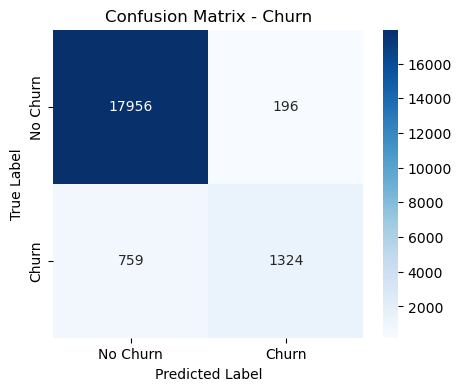

📑 Classification Report - Churn
              precision    recall  f1-score   support

    No Churn       0.96      0.99      0.97     18152
       Churn       0.87      0.64      0.73      2083

    accuracy                           0.95     20235
   macro avg       0.92      0.81      0.85     20235
weighted avg       0.95      0.95      0.95     20235



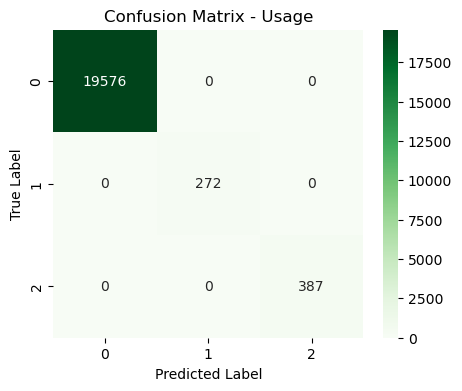

📑 Classification Report - Usage
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00     19576
      Medium       1.00      1.00      1.00       272
        High       1.00      1.00      1.00       387

    accuracy                           1.00     20235
   macro avg       1.00      1.00      1.00     20235
weighted avg       1.00      1.00      1.00     20235



In [34]:
# Extract test labels from Y_test
y_test_churn = y_test["Churn"]
y_test_usage = y_test["UsageCategory"]

# Extract predictions
churn_pred = y_pred[:, 0]
usage_pred = y_pred[:, 1]


# 📊 Confusion Matrix & Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ---- Confusion Matrix for Churn ----
cm_churn = confusion_matrix(y_test_churn, churn_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_churn, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn","Churn"], yticklabels=["No Churn","Churn"])
plt.title("Confusion Matrix - Churn")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

print("📑 Classification Report - Churn")
print(classification_report(y_test_churn, churn_pred, target_names=["No Churn","Churn"]))


# ---- Confusion Matrix for Usage ----
cm_usage = confusion_matrix(y_test_usage, usage_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_usage, annot=True, fmt="d", cmap="Greens", xticklabels=np.unique(y_test_usage), yticklabels=np.unique(y_test_usage))
plt.title("Confusion Matrix - Usage")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

print("📑 Classification Report - Usage")
print(classification_report(y_test_usage, usage_pred, target_names=["Low","Medium","High"]))
